# Explore different embedding spaces of Axiom data

Look at PCA and UMAP of Axiom data with different features. Explore how correlated the Dino and CP CNN features are.

In [1]:
# Imports
import polars as pl
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

In [234]:
# Paths
feat_path = "/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect"
prof_path = f"{feat_path}/profiles/mad_featselect.parquet"

#prof_path = "/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/inputs/profiles/dino/raw.parquet"

In [235]:
data = pl.read_parquet(prof_path)

cc = pl.read_parquet(f"{feat_path}/curves/ccpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cc_POD"})
ldh = pl.read_parquet(f"{feat_path}/curves/ldhpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_ldh_POD"})
mtt = pl.read_parquet(f"{feat_path}/curves/mttpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_mtt_POD"})
morph = pl.read_parquet(f"{feat_path}/curves/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_morph_POD"})

data = data.join(cc, on="Metadata_Compound", how="left")
data = data.join(ldh, on="Metadata_Compound", how="left")
data = data.join(mtt, on="Metadata_Compound", how="left")
data = data.join(morph, on="Metadata_Compound", how="left")

In [236]:
# Add columns to label different sample subsets based on their bioactivity
data = data.with_columns(
    (pl.col("Metadata_Log10Conc") > pl.col("Metadata_morph_POD")).alias("Metadata_Bioactive"),
    (pl.col("Metadata_Log10Conc") < pl.col("Metadata_cc_POD")).alias("Metadata_No_Cytotox"),
)

data = data.with_columns(
    pl.when(pl.col("Metadata_Bioactive") == False)
    .then(False)
    .when(pl.col("Metadata_Bioactive") == True)
    .then(True)
    .otherwise(False)
    .alias("Metadata_Bioactive"),
)
data = data.with_columns(
    pl.when(pl.col("Metadata_No_Cytotox") == False)
    .then(False)
    .when(pl.col("Metadata_No_Cytotox") == True)
    .then(True)
    .otherwise(True)
    .alias("Metadata_No_Cytotox"),
)

metadata_cols = [col for col in data.columns if "Metadata" in col]

data = data.to_pandas()
data.sort_values(["Metadata_Plate", "Metadata_Well"], inplace=True)
data.index = [f"{row['Metadata_Plate']}__{row['Metadata_Well']}" for _, row in data.iterrows()]
data = data.loc[~data.index.duplicated(keep="first")]

metadata = data[metadata_cols]
adata = anndata.AnnData(X=data.drop(metadata_cols, axis=1))
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

# Plot UMAPs (only bioactive samples)
bioactive_mask = adata.obs["Metadata_Bioactive"]
adata_bioactive = adata[bioactive_mask].copy()
print(f"Bioactive samples: {adata_bioactive.shape}")

# Plot UMAPs (only bioactive & non-cytotoxic samples)
nocytotox_mask = adata_bioactive.obs["Metadata_No_Cytotox"]
adata_nocytotox = adata_bioactive[nocytotox_mask].copy()
print(f"Bioactive & non-cytotoxic samples: {adata_nocytotox.shape}")

Bioactive samples: (2981, 4432)
Bioactive & non-cytotoxic samples: (2177, 4432)


Probably showing batch at the tail ends of the cell count pattern, unless groups of compounds with similar MOA were put in the same batch. Those batches are mixed elsewhere, so perhaps this is the explanation. 

## Compare features

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


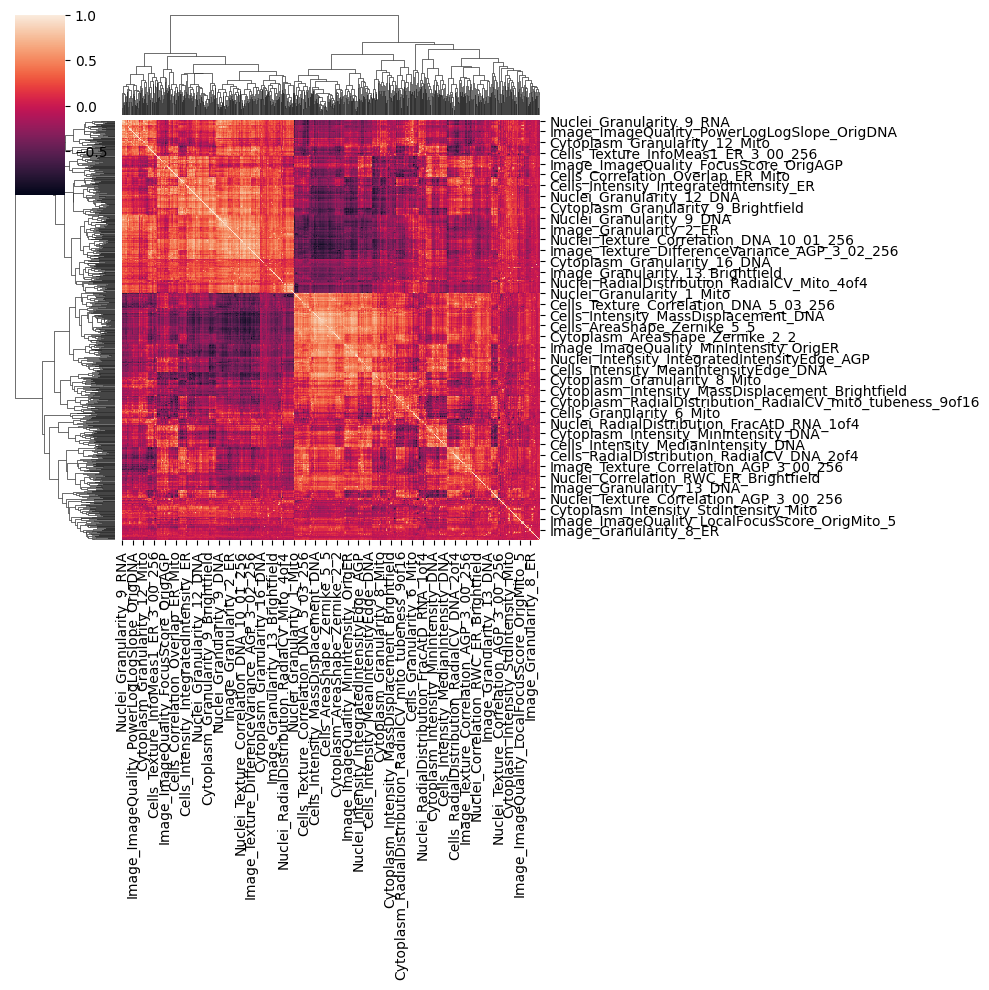

In [106]:
data_matrix = pl.DataFrame(adata.X.T).to_numpy()
correlation_matrix = np.corrcoef(data_matrix)
sns.clustermap(pd.DataFrame(correlation_matrix, index=adata.var_names, columns=adata.var_names), figsize=(10, 10))

In [42]:
# How many compounds had cell count decrease
cc = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/ccpods.parquet")
print(f"cell count: {cc.select('all.pass').sum().item()}")

ldh = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/ldhpods.parquet")
print(f"LDH: {ldh.select('all.pass').sum().item()}")

mtt = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/mttpods.parquet")
print(f"MTT: {mtt.select('all.pass').sum().item()}")

morph = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/pods.parquet")
print(f"morphology: {len(morph.select('Metadata_Compound').to_series().unique().to_list())}")

cell count: 220
LDH: 147
MTT: 428
morphology: 620


This makes sense - we expect morphology to pick up on more things than MTT/cell count/LDH, and we also expect less LDH than cell count since it is detecting a specific type of cell death (necrosis).

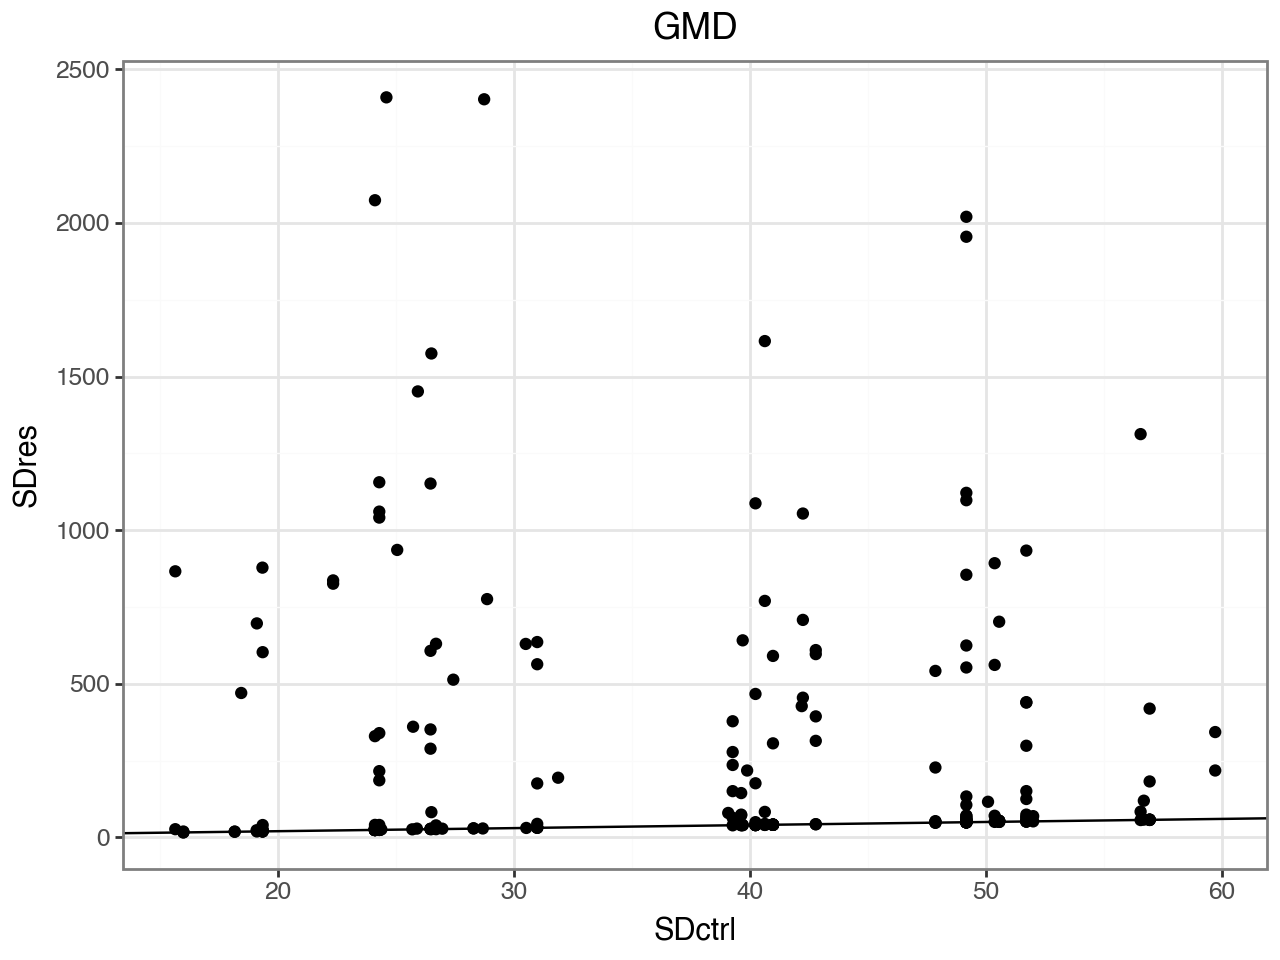

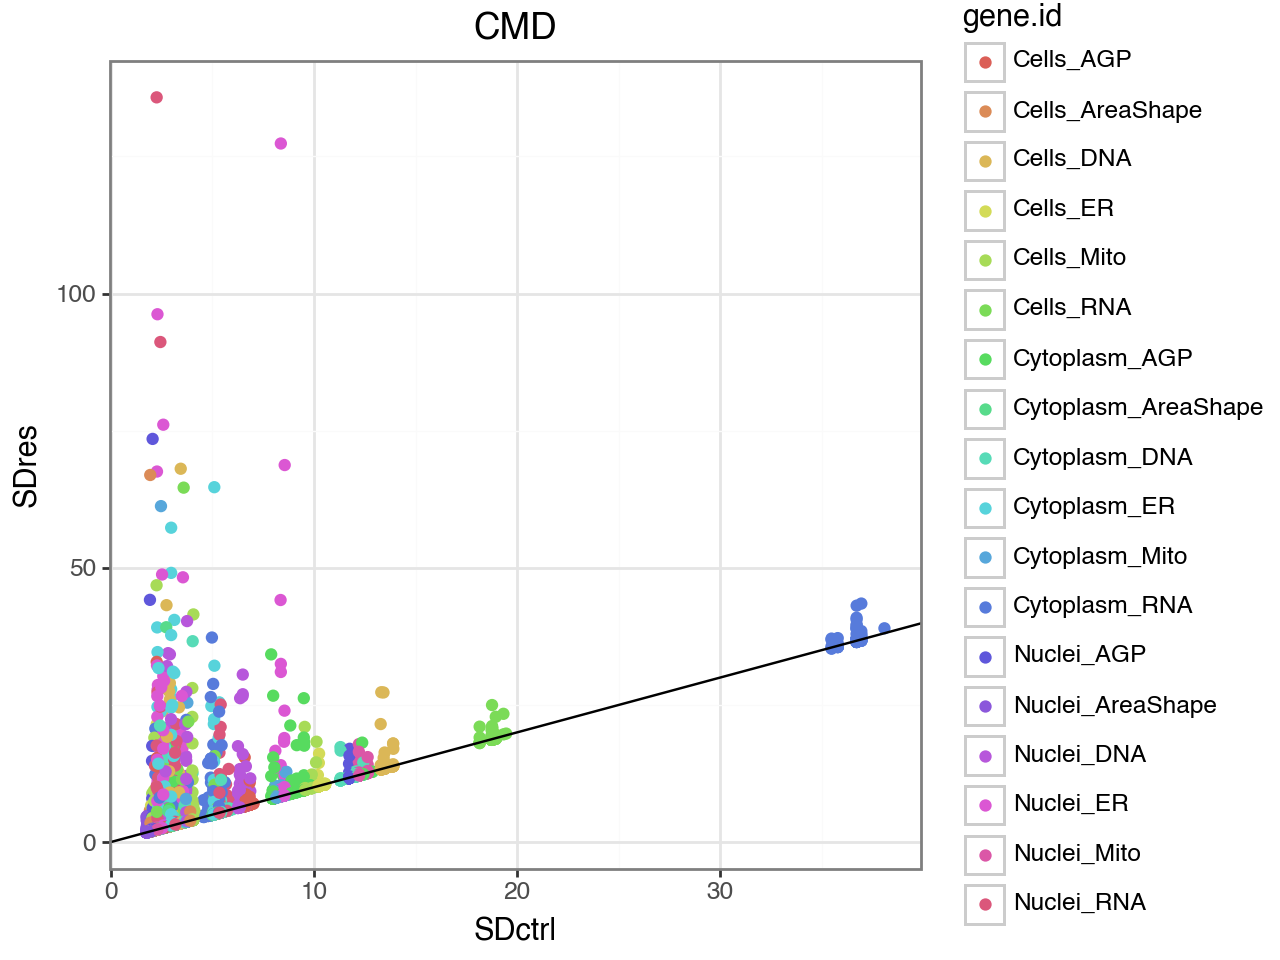

/var/folders/g0/nk06fpgs01z6zmr4x7kvp0g80000gp/T/ipykernel_25997/1833647596.py:27: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.


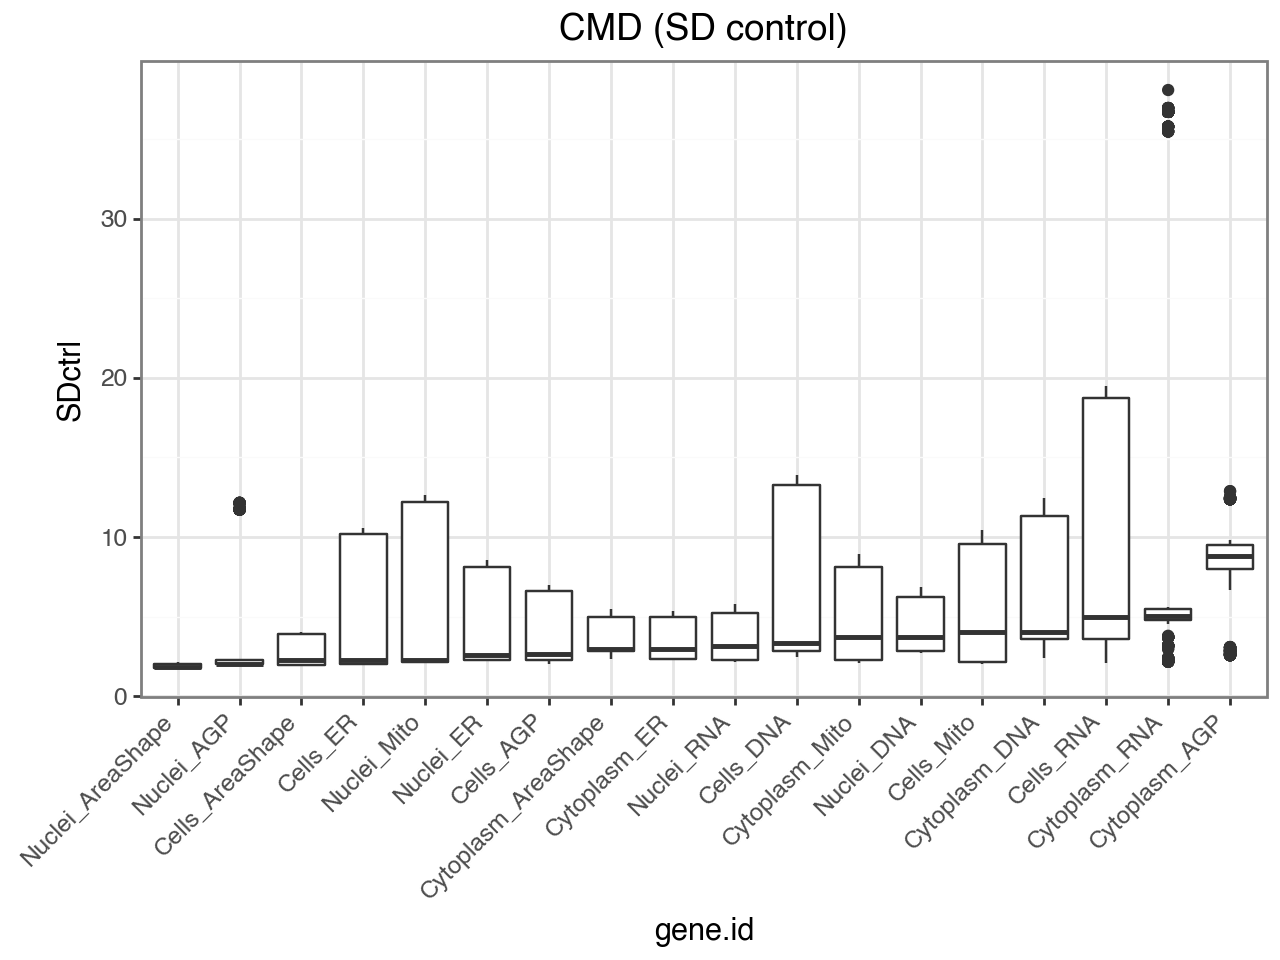

In [1]:
from plotnine import ggplot, geom_point, theme_bw, aes, labs, geom_abline, geom_boxplot, theme, element_text
import polars as pl

bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/curves/bmds.parquet")
bmds = bmds.filter((pl.col("conv.pass") == "true") & (pl.col("hd.pass") == "true") & (pl.col("CI.pass") == "true"))

bmd_gmd = bmds.filter(pl.col("gene.id") == "gmd")
bmd_cmd = bmds.filter(pl.col("gene.id") != "gmd")

plot = (ggplot(bmd_gmd, aes(x="SDctrl", y="SDres")) +
        geom_point() +
        theme_bw() +
        labs(title="GMD") +
        geom_abline(intercept=0, slope=1)
        )
plot.show()

plot = (ggplot(bmd_cmd, aes(x="SDctrl", y="SDres", color="gene.id")) +
        geom_point() +
        theme_bw() +
        labs(title="CMD") +
        geom_abline(intercept=0, slope=1)
        )
plot.show()

medians = (
    bmd_cmd.groupby("gene.id")
    .agg(pl.median("SDctrl").alias("median_SDctrl"))
    .sort("median_SDctrl")
).select("gene.id").to_series().to_list()

bmd_cmd = bmd_cmd.with_columns(
        pl.col("gene.id").cast(pl.Enum(medians))
)

plot = (ggplot(bmd_cmd, aes(x="gene.id", y="SDctrl")) +
        geom_boxplot() +
        theme_bw() +
        theme(axis_text_x=element_text(rotation=45, hjust=1)) +
        labs(title="CMD (SD control)")
        )
plot.show()

In [31]:
# dino - gmd
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/bmds.parquet")
bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true") & (pl.col("SDres") < 6)
).select("Metadata_Compound").to_series().unique().shape

(356,)

In [32]:
# cpcnn - only has gmd (WHY IS THIS DIFFERENT THAN ABOVE? --> because I have a random SDRES < 6 requirement in pod selection)
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cpcnn/mad_featselect/curves/bmds.parquet")
bmds = bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true") & (pl.col("SDres") < 6)
)

bmds.select("Metadata_Compound").to_series().unique().shape

(353,)

In [34]:
# dino - including categorical
dino = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/pods.parquet")
len(dino.select("Metadata_Compound").to_series().unique().to_list())

620

In [35]:
# cellprofiler - including categorical
cp = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/curves/pods.parquet")
len(cp.select("Metadata_Compound").to_series().unique().to_list())

589